In [61]:
#!pip install wordcloud
#!pip install -U pip setuptools wheel
#!pip install -U spacy
#!python -m spacy download en_core_web_sm

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import spacy
import gensim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.probability import FreqDist
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, GRU, SimpleRNN

In [63]:
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print("Downloading spaCy model...")
    # Download the model if it's not found
    from spacy.cli import download
    download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

In [64]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidjuradodepriegoinverno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CARGA DE DATOS

In [65]:
df = pd.read_json('/Users/davidjuradodepriegoinverno/Documents/Bootcamp/Entregas/KeepCodingBDML13/Modulo_10_NLP/Software.json', lines=True)
df = pd.DataFrame(df[['overall','reviewText']])

num_samples = 10000
sampled_df_1 = df[df['overall'] == 1].sample(n=num_samples)
sampled_df_2 = df[df['overall'] == 2].sample(n=num_samples)
sampled_df_3 = df[df['overall'] == 3].sample(n=num_samples*2)
sampled_df_4 = df[df['overall'] == 4].sample(n=num_samples)
sampled_df_5 = df[df['overall'] == 5].sample(n=num_samples)
df = pd.concat([sampled_df_1, sampled_df_2, sampled_df_3, sampled_df_4, sampled_df_5])

df.to_csv('data.csv', index=False)

In [66]:
df = pd.read_csv('/Users/davidjuradodepriegoinverno/Documents/Bootcamp/Entregas/KeepCodingBDML13/Modulo_10_NLP/data.csv')
df.head()

,overall,reviewText
0,1,While I've been pretty loyal to Norton in the ...
1,1,I have used this program for about two years n...
2,1,First iam not completely knocking data pilot p...
3,1,I purchased this product and installed it with...
4,1,"As a Mac user since 1989, I have used Word sin..."


División train y test

In [67]:
train = df.sample(frac = 0.75)
test = df.drop(train.index)

Análisis exploratorio y limpieza

In [68]:
train = train.dropna(subset=['reviewText', 'overall'])
X_train = train['reviewText']
y_train = train['overall']
print(X_train.shape)
print(y_train.shape)

(44995,)
(44995,)


In [69]:
test = test.dropna(subset=['reviewText', 'overall'])
X_test = test['reviewText']
y_test = test['overall']
print(X_test.shape)
print(y_test.shape)

(15000,)
(15000,)


/Users/davidjuradodepriegoinverno/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


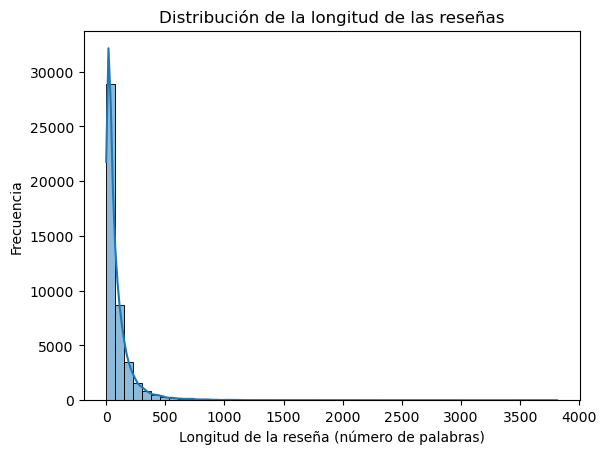

In [70]:
# Longitud de las reseñas
X_train_length = X_train.apply(lambda x: len(x.split()))
sns.histplot(X_train_length, bins=50, kde=True)
plt.title('Distribución de la longitud de las reseñas')
plt.xlabel('Longitud de la reseña (número de palabras)')
plt.ylabel('Frecuencia')
plt.show()

/Users/davidjuradodepriegoinverno/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


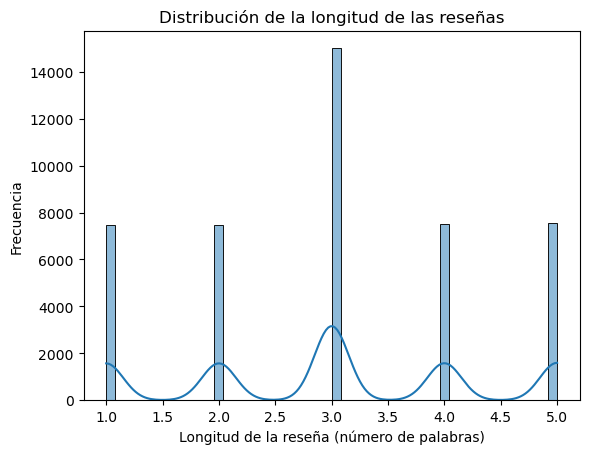

In [71]:
# Distribución puntuaciones
sns.histplot(y_train, bins=50, kde=True)
plt.title('Distribución de la longitud de las reseñas')
plt.xlabel('Longitud de la reseña (número de palabras)')
plt.ylabel('Frecuencia')
plt.show()

In [72]:
table = str.maketrans('', '', string.punctuation)

In [73]:
sentiment = 1

def get_data_by_sentiment(sentiment, stop_words):
    combined_text = " ".join([review.lower().translate(table) for review in train.loc[train['overall'] == sentiment]['reviewText']])

    wc = WordCloud(background_color='white', max_words=50, stopwords = stop_words)

    plt.imshow(wc.generate(combined_text))
    plt.axis('off')
    plt.show()
    
    word_tokens = word_tokenize(combined_text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    word_freqs = Counter(filtered_sentence)
    words = [w[0] for w in word_freqs.most_common(20)]
    freqs = [w[1] for w in word_freqs.most_common(20)]
    freqs, words = zip(*sorted(zip(freqs, words)))
    plt.barh(words, freqs)
    plt.show()
    
    bigrams = list(ngrams(filtered_sentence, 2))
    trigrams = list(ngrams(filtered_sentence, 3))
    bg_freq = FreqDist(bigrams)
    tg_freq = FreqDist(trigrams)
    bg_freq_most_common = bg_freq.most_common(10)
    bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
    bgs_f_ = [bg[1] for bg in bg_freq_most_common]

    tg_freq_most_common = tg_freq.most_common(10)
    tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
    tgs_f_ = [tg[1] for tg in tg_freq_most_common]
    bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
    tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

    plt.barh(bgs_, bgs_f_)
    plt.title(f'Bigram frequencies {sentiment}')
    plt.show()
    
    plt.barh(tgs_, tgs_f_)
    plt.title(f'Trigram frequencies {sentiment}')
    plt.show()

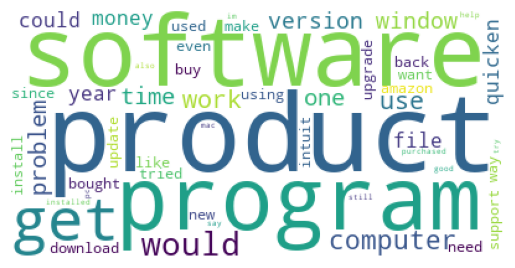

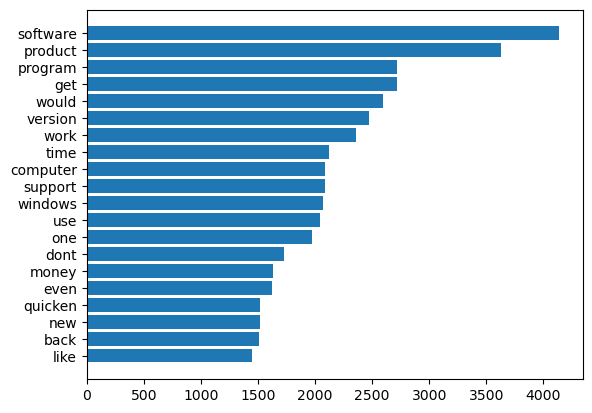

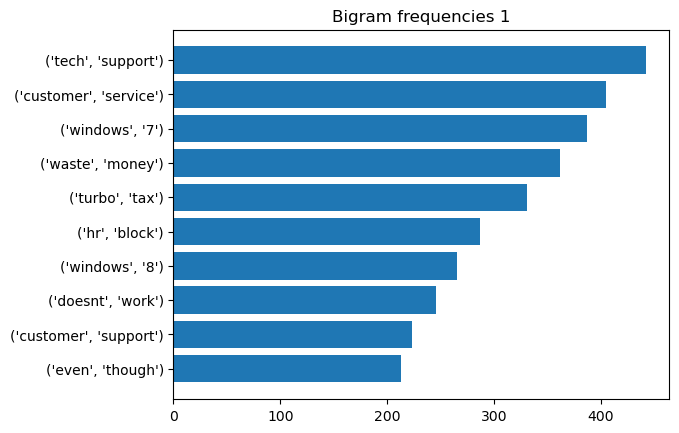

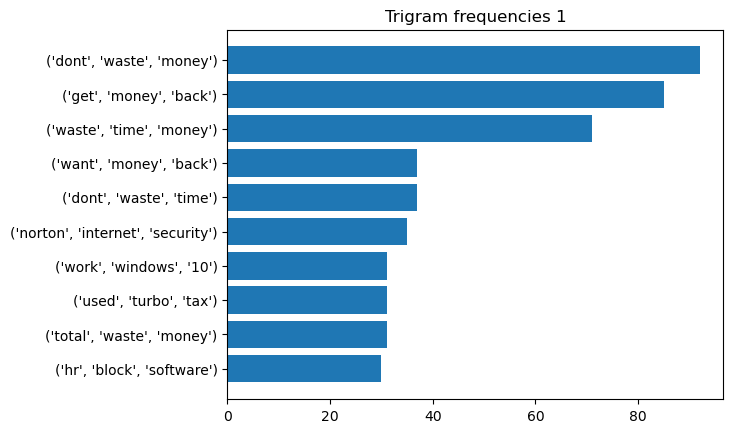

In [74]:
get_data_by_sentiment(1, stop_words)

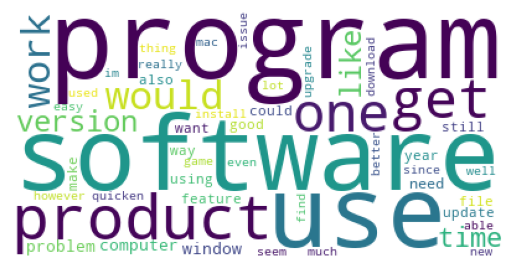

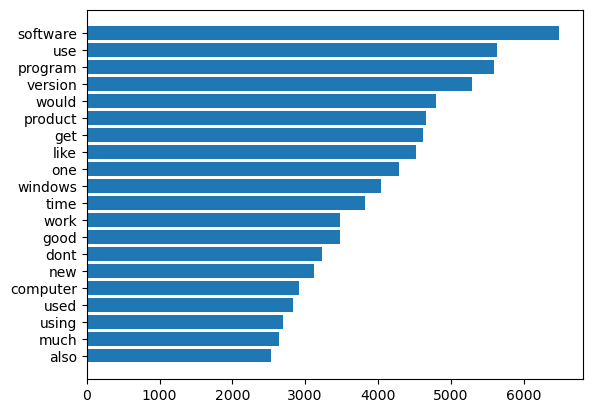

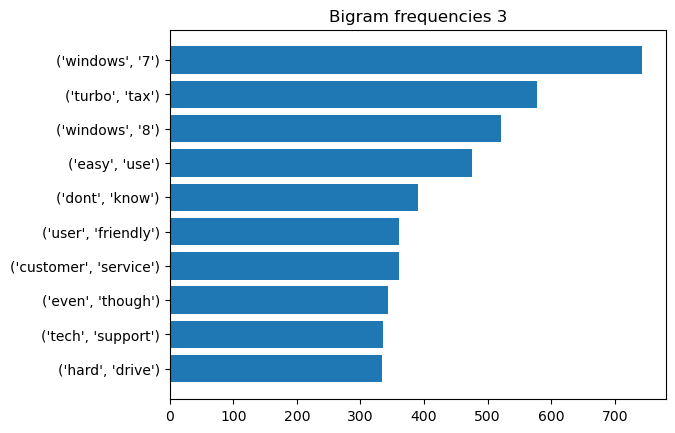

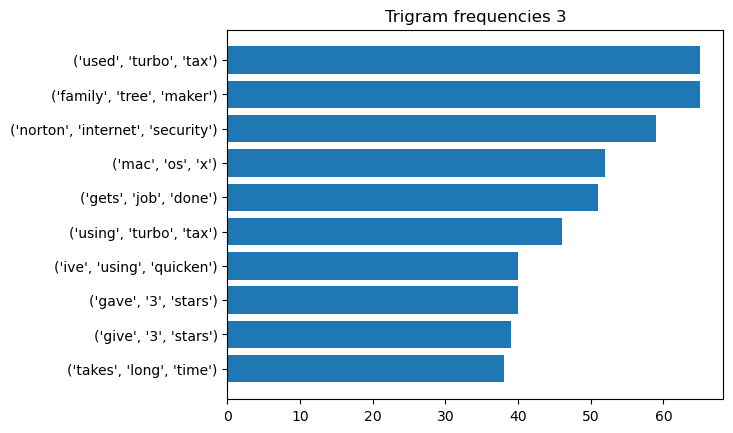

In [75]:
get_data_by_sentiment(3, stop_words)

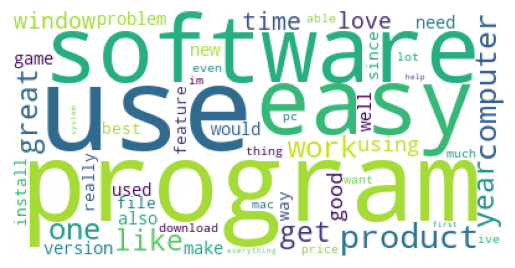

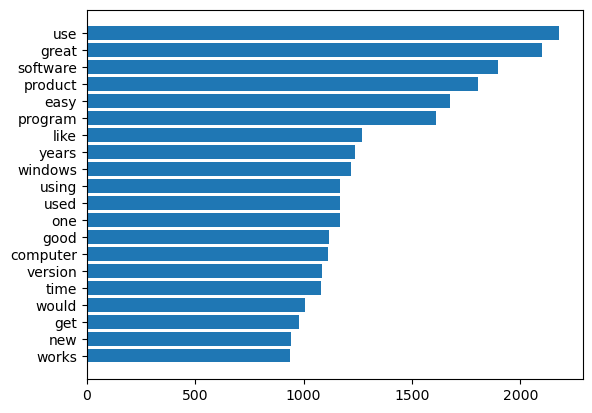

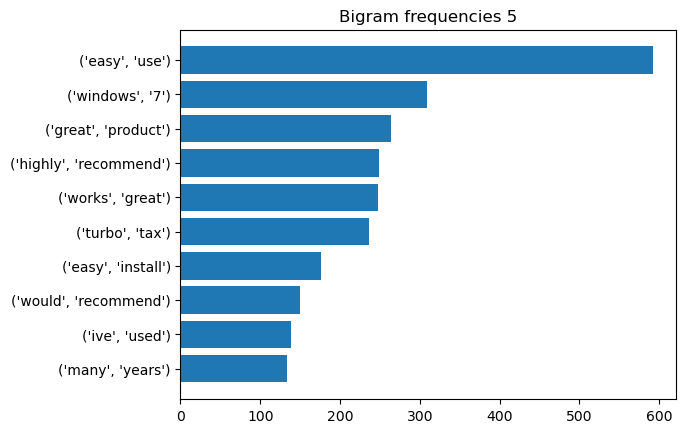

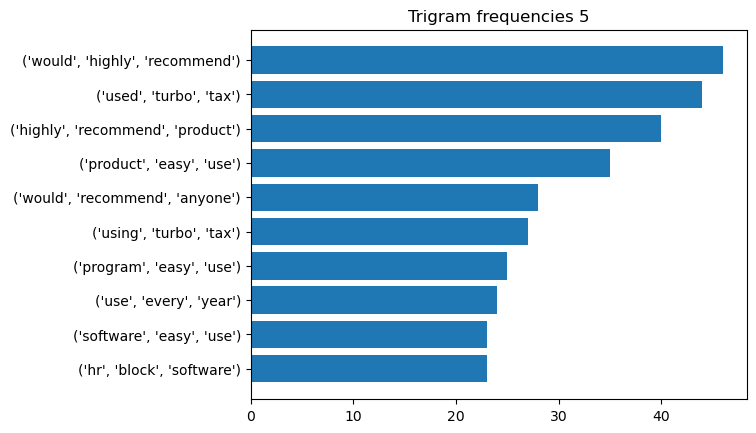

In [76]:
get_data_by_sentiment(5, stop_words)

Preprocesado y word2vec

In [77]:
def lemmatize_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    return tokens

lemmatized_texts = X_train.apply(lambda x: " ".join(lemmatize_text(x)))

filtered_tokens = []
for text in lemmatized_texts:
    tokens = text.split()
    filtered_tokens.extend([w for w in tokens if w not in stop_words])

word_freqs = Counter(filtered_tokens)

new_stopwords = [w[0] for w in word_freqs.most_common(50)]

stop_words.update(new_stopwords)

print("Nuevas stop words añadidas:")
print(new_stopwords)

Nuevas stop words añadidas:
['work', 'software', 'program', 'product', 'version', 'use', 'year', 'time', 'like', 'good', 'computer', 'buy', 'find', 'need', 'new', 'try', 'problem', 'windows', 'file', 'want', 'download', 'easy', 'get', 'support', 'update', 'quicken', 'upgrade', 'great', 'user', 'run', 'purchase', 'feature', 'think', 'go', 'thing', 'way', 'old', 'well', 'know', 'install', 'look', 'system', 'mac', 'tax', 'help', 'money', 'instal', 'come', 'start', 'take']


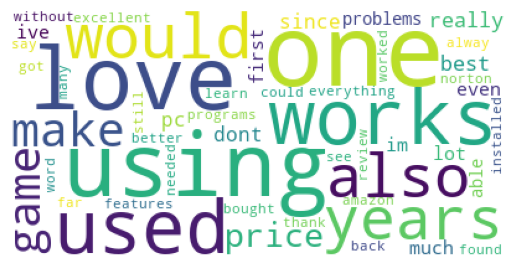

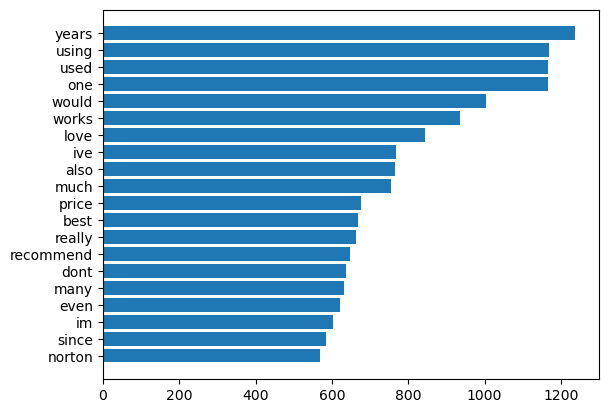

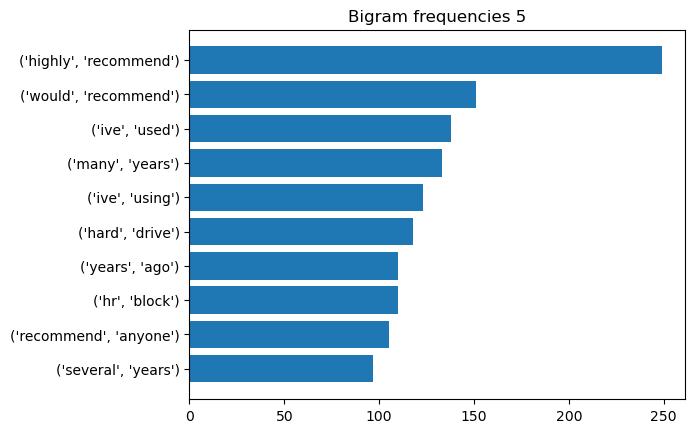

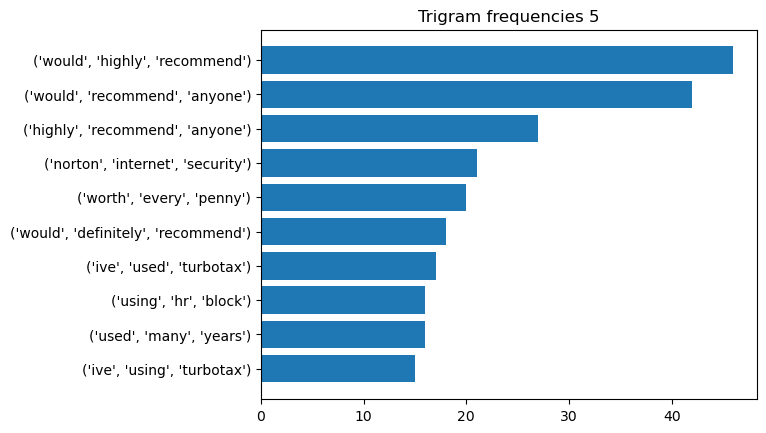

In [78]:
get_data_by_sentiment(5, stop_words)

In [79]:
def preprocess_text(text):
    doc = nlp(text.lower())  
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.lemma_ not in stop_words] 
    return ' '.join(tokens)

X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

tokenized_train = X_train.apply(lambda x: x.split())
model_w2v = gensim.models.Word2Vec(tokenized_train, vector_size=100, window=5, min_count=5, sg=1)
model_w2v.save('./model_w2v.pkl')

def get_review_vector(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

X_train_vec = tokenized_train.apply(lambda x: get_review_vector(x, model_w2v, 100))
X_train_vec = np.vstack(X_train_vec)
X_test_vec = X_test.apply(lambda x: get_review_vector(x.split(), model_w2v, 100))
X_test_vec = np.vstack(X_test_vec)

In [80]:
vocab_len = len(model_w2v.wv.key_to_index)
print(f'Vocabulario compuesto por {vocab_len} palabras')

Vocabulario compuesto por 10715 palabras


/var/folders/27/snbyyprn3ql1rrzc41fq2rg40000gn/T/ipykernel_23444/2900758526.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


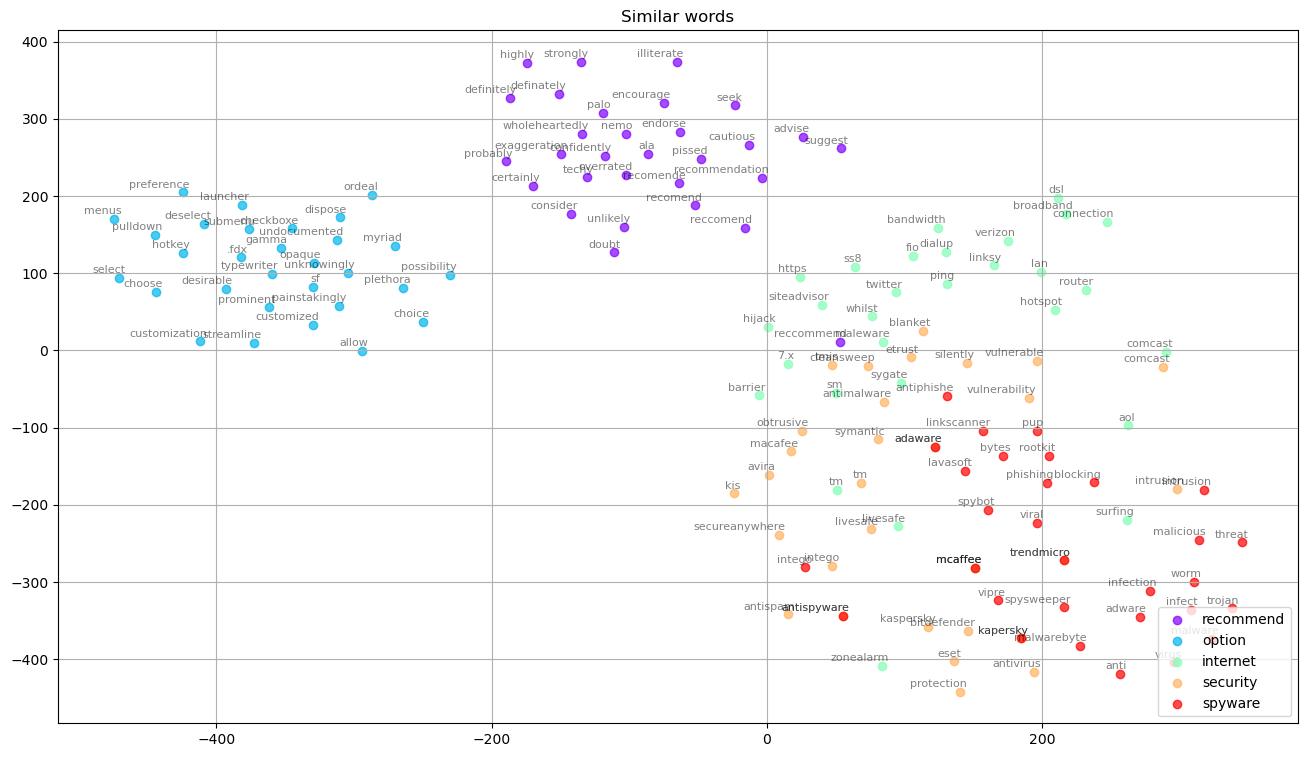

In [81]:
keys = ['recommend', 'option', 'internet', 'security', 'spyware']

embedding_clusters = []
word_clusters = []
    
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model_w2v.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model_w2v.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()
    
tsne_plot_similar_words('Similar words', keys, embeddings_en_2d, word_clusters, 0.7, 'similar_words.png')

In [82]:
def get_sentiment(overall):
    if overall > 3:
        return 1  # Reseña positiva
    elif overall < 3:
        return 0  # Reseña negativa
    else:
        return 2  # Reseña neutral

y_train = y_train.apply(get_sentiment).astype(int)
y_test = y_test.apply(get_sentiment).astype(int)

In [83]:
y_train.describe()

count    44995.000000
mean         1.001867
std          0.815541
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: overall, dtype: float64

Entrenamiento ML - GradientBoostingClassifier

In [84]:
# Entrenar el modelo GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(X_train_vec, y_train)

# Predicciones
y_pred = model.predict(X_test_vec)

# Evaluación del modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5552666666666667
Confusion Matrix:
[[3184  709 1186]
 [ 755 3017 1155]
 [1573 1293 2128]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.63      0.60      5079
           1       0.60      0.61      0.61      4927
           2       0.48      0.43      0.45      4994

    accuracy                           0.56     15000
   macro avg       0.55      0.56      0.55     15000
weighted avg       0.55      0.56      0.55     15000



Entrenamiento DML - LSTM

In [85]:
embedding_size = 32
input_length = 100

inputs = Input(shape=(input_length,))
embedding_layer = Embedding(input_dim=vocab_len, output_dim=embedding_size, input_shape=(100,))(inputs)
lstm_layer = LSTM(100)(embedding_layer)
outputs = Dense(1, activation='sigmoid')(lstm_layer)

model = Model(inputs=inputs, outputs=outputs)

print(model.summary())

/Users/davidjuradodepriegoinverno/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 32)        │       342,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        53,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 396,181 (1.51 MB)

 Trainable params: 396,181 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

None


In [86]:
batch_size = 256
num_epochs = 25
lr = 0.001
opt = Adam(learning_rate=lr)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

X_valid, y_valid = X_train_vec[:batch_size], y_train[:batch_size]
X_train2, y_train2 = X_train_vec[batch_size:], y_train[batch_size:]

H = model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs)

Epoch 1/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - accuracy: 0.3364 - loss: 0.1115 - val_accuracy: 0.2969 - val_loss: -1.1494
Epoch 2/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - accuracy: 0.3300 - loss: 0.0552 - val_accuracy: 0.2969 - val_loss: -1.1359
Epoch 3/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step - accuracy: 0.3370 - loss: -0.1080 - val_accuracy: 0.2969 - val_loss: -1.2882
Epoch 4/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 24s 139ms/step - accuracy: 0.3347 - loss: -0.0667 - val_accuracy: 0.2969 - val_loss: -1.3309
Epoch 5/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.3348 - loss: 0.0638 - val_accuracy: 0.2969 - val_loss: -1.3761
Epoch 6/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 25s 141ms/step - accuracy: 0.3350 - loss: -0.0908 - val_accuracy: 0.2969 - val_loss: -1.4706
Epoch 7/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step - accuracy: 0.3360 - loss: -0.0851 - val_accuracy: 0.2969 - val_loss: -1.4768
Epoch 8/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.329

In [87]:
predictions_train = model.predict(X_train2, batch_size=batch_size)
predictions_val = model.predict(X_valid, batch_size=batch_size)
predictions_test = model.predict(X_test_vec, batch_size=batch_size)

eval_test = model.evaluate(X_test_vec, y_test)
print(eval_test)

175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0621 - loss: 10.2431
[0.12362273782491684, 0.32846665382385254]


[]

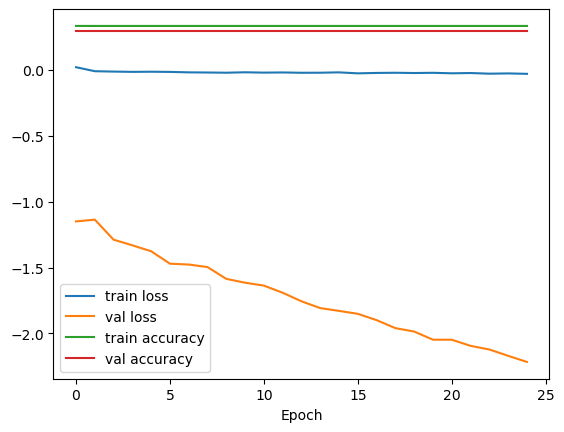

In [88]:
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['val_loss'], label='val loss')
plt.plot(H.history['accuracy'], label='train accuracy')
plt.plot(H.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.xlabel('Epoch')
#ax = plt.gca()
#ax.set_ylim([0, 0.6])
plt.plot()

Entrenamiento DML - GRU

In [89]:
embedding_size = 32
input_length = 100

inputs = Input(shape=(input_length,))
embedding_layer = Embedding(input_dim=vocab_len, output_dim=embedding_size, input_shape=(100,))(inputs)
gru_layer = GRU(100)(embedding_layer)
outputs = Dense(1, activation='sigmoid')(gru_layer)

model = Model(inputs=inputs, outputs=outputs)

print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 100, 32)        │       342,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 383,181 (1.46 MB)

 Trainable params: 383,181 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

None


In [90]:
batch_size = 256
num_epochs = 25
lr = 0.001
opt = Adam(learning_rate=lr)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

X_valid, y_valid = X_train_vec[:batch_size], y_train[:batch_size]
X_train2, y_train2 = X_train_vec[batch_size:], y_train[batch_size:]

H = model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs)

Epoch 1/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 28s 157ms/step - accuracy: 0.3342 - loss: 0.1203 - val_accuracy: 0.2969 - val_loss: -1.0213
Epoch 2/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.3395 - loss: 0.0087 - val_accuracy: 0.2969 - val_loss: -1.0959
Epoch 3/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 0.3312 - loss: -0.0496 - val_accuracy: 0.2969 - val_loss: -1.1888
Epoch 4/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - accuracy: 0.3348 - loss: 0.0352 - val_accuracy: 0.2969 - val_loss: -1.2126
Epoch 5/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.3363 - loss: -0.0481 - val_accuracy: 0.2969 - val_loss: -1.3242
Epoch 6/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - accuracy: 0.3336 - loss: -0.1564 - val_accuracy: 0.2969 - val_loss: -1.3768
Epoch 7/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 26s 151ms/step - accuracy: 0.3364 - loss: -0.0383 - val_accuracy: 0.2969 - val_loss: -1.4305
Epoch 8/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 153ms/step - accuracy: 0.336

In [91]:
predictions_train = model.predict(X_train2, batch_size=batch_size)
predictions_val = model.predict(X_valid, batch_size=batch_size)
predictions_test = model.predict(X_test_vec, batch_size=batch_size)

eval_test = model.evaluate(X_test_vec, y_test)
print(eval_test)

175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0621 - loss: 10.3345
[0.12519747018814087, 0.32846665382385254]


[]

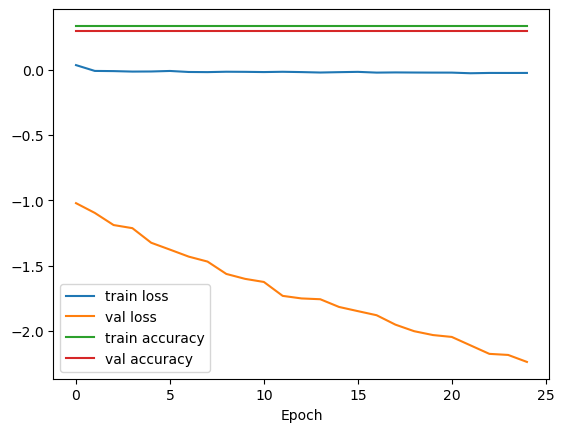

In [92]:
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['val_loss'], label='val loss')
plt.plot(H.history['accuracy'], label='train accuracy')
plt.plot(H.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.xlabel('Epoch')
#ax = plt.gca()
#ax.set_ylim([0, 0.6])
plt.plot()

Conclusiones

La performance de los modelos no es la adecuada, lo que indica que son necesarios pasos adicionales en la parte de preprocesado. Por ejemplo habría que escoger mejor stopwords para reducir el tamaño del vocabulario y quedarnos con las palabras más relevantes. Aunque hemos añadido las 50 palabras más comunes como stopwords se podría trabajar esa parte con más profundidad.

Otros pasos que podrían ayudar a mejorar los modelos:
- Combinar Word2Vec y TF-IDF. Esta técnica podría mejorar la representatividad de los vectores.
- Optimización de Hiperparámetros: Mejorar el rendimiento del modelo mediante la búsqueda de hiperparámetros. Por ejemplo el min_count del word2vec o un randomSearch en las hiperparámetros de los modelos
- Incluir N-grams como características adicionales
- Usar embeddings preentrenados o modelos tipo transformer que ya tienen parte del lenguaje entrenado y que funcionan muy bien en tareas de clasificación